In [12]:
import functions
from pprint import pprint
import matplotlib.pyplot as plt
import sys, operator
import yaml
import math
from matplotlib.lines import Line2D

In [7]:
# The GTO data from Head-Gordon et al for a subset of functionals
# The data extracted here is automatically writted to hg_data.yaml" as well.
hg_data = functions.get_HG_data("hg_data.csv", functionals=["ccsd(t)", "pbe", "pbe0", "spw92"])

# The multiwavelet data, first derivative finite difference based on dipoles
with open("mw_data_0001v2.yaml") as f:
    mw_data = yaml.load(f)

In [5]:
# All data are stored in dictionaries. For example, the HG data for AlF is
hg_data["alf"]

{'ccsd(t)': {'diagonal': [5.971, 5.971, 5.132], 'mean': 5.691333333333333},
 'pbe': {'diagonal': [6.292, 6.292, 5.656], 'mean': 6.079999999999999},
 'pbe0': {'diagonal': [6.248, 6.248, 5.378], 'mean': 5.958000000000001},
 'spin': 'NSP',
 'spw92': {'diagonal': [6.154, 6.154, 5.59], 'mean': 5.966}}

In [6]:
# Reproduce their published MRE values to make sure the data we have is correct
molecules_all = [mol for mol in hg_data.keys()]
for func in ["pbe", "pbe0"]:
    # Get the relative errors for each pol component
    mre_xx = sum([100 * (hg_data[mol][func]["diagonal"][0] / hg_data[mol]["ccsd(t)"]["diagonal"][0] - 1) for mol in molecules_all]) / len(molecules_all)
    mre_yy = sum([100 * (hg_data[mol][func]["diagonal"][1] / hg_data[mol]["ccsd(t)"]["diagonal"][1] - 1) for mol in molecules_all]) / len(molecules_all)
    mre_zz = sum([100 * (hg_data[mol][func]["diagonal"][2] / hg_data[mol]["ccsd(t)"]["diagonal"][2] - 1) for mol in molecules_all]) / len(molecules_all)
    
    mre_tot = sum([mre_xx, mre_yy, mre_zz]) / 3
    print(func, mre_tot)

('pbe', 7.906210933634736)
('pbe0', 2.836532505810867)


In [5]:
## Now produce some plots 
## Top axes: The relative error between GTO and MW polarizabilities for each molecule, using MW
##           as reference: RE = (GTO - MW) / MW * 100.
##   
##           Color coding: blue for non-spin polarized molecules
##                         red  for     spin polarized molecules
##  
## Bottom axes: Compare both MW and GTO polarizabilities to the CCSD(t) reference provided by HG et al.
##              using the CC results as reference.
##   
##              Color coding: black for GTO relative errors
##                            blue  for non-spin polarized MW relative errors
##                            red   for     spin polarized MW relative errors

## First for the PBE functional, then for LDA(MW)/SPW92(GTO)

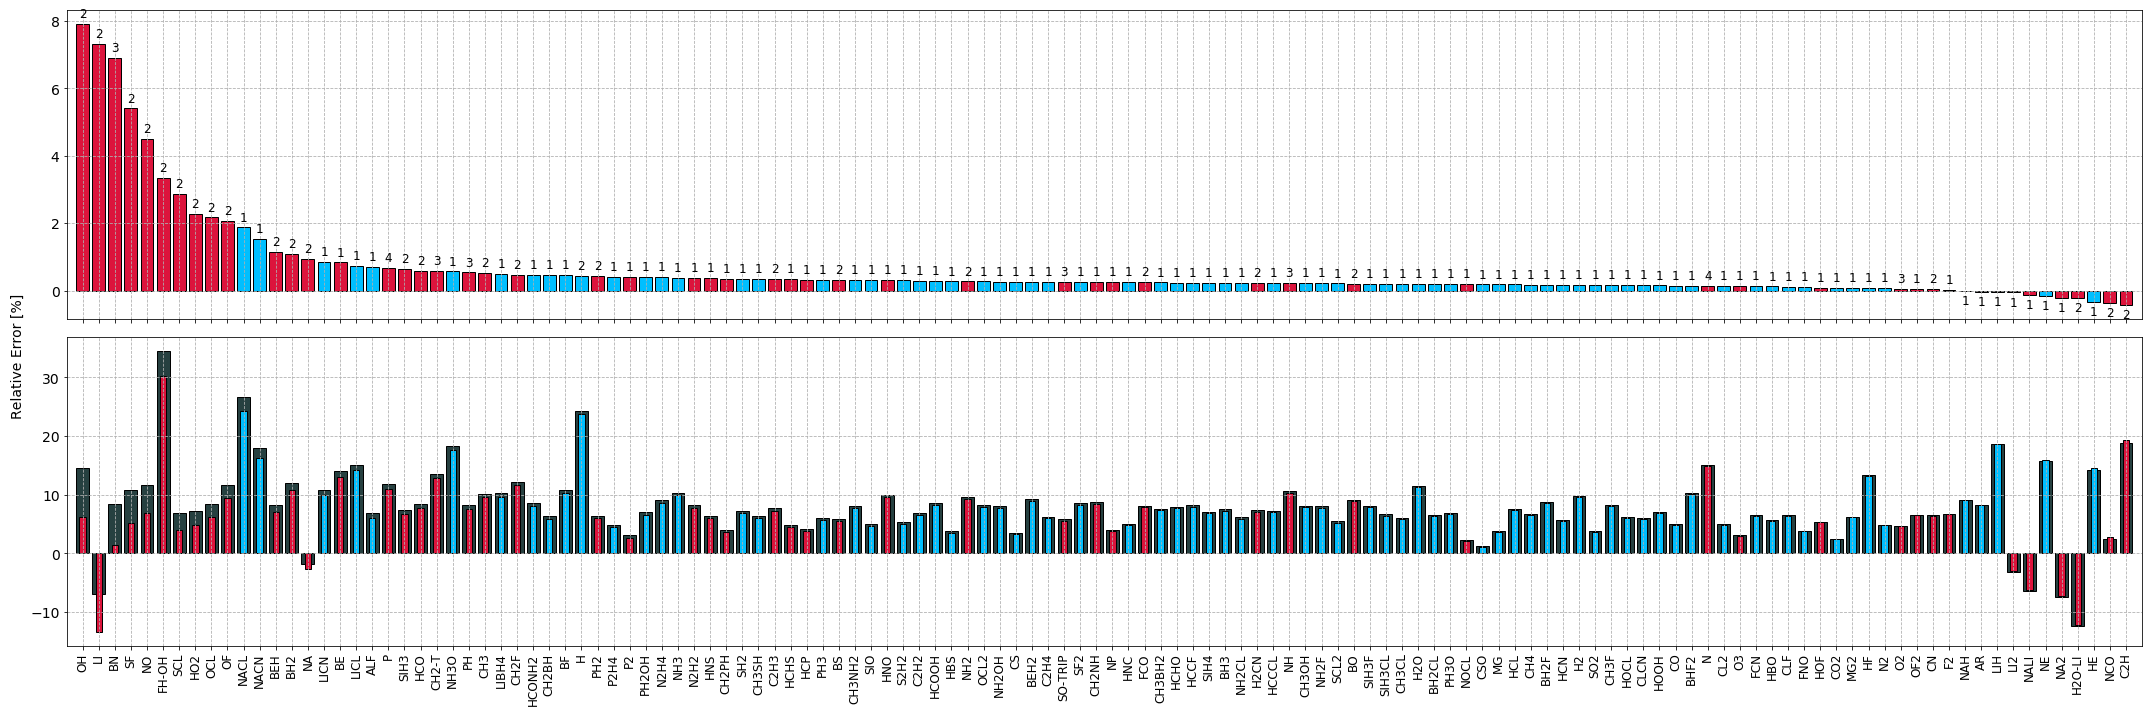

In [8]:
# 4 molecules () are missing from the MW dataset, so we base all comparisons on the keys of mw_data
molecules = [mol for mol in mw_data.keys()]

# Define the xticks for the plots
xticks = range(len(molecules))

# Now extract the data we want
rel_err_pbe    = [100 * (hg_data[mol]["pbe"]["mean"] / mw_data[mol]["pbe"]["mean"]     - 1) for mol in molecules]
rel_err_mw_cc  = [100 * (mw_data[mol]["pbe"]["mean"] / hg_data[mol]["ccsd(t)"]["mean"] - 1) for mol in molecules]
rel_err_gto_cc = [100 * (hg_data[mol]["pbe"]["mean"] / hg_data[mol]["ccsd(t)"]["mean"] - 1) for mol in molecules]

# Sort data based on the PBE relative error results, by zip-sort-unzip
molecules_sorted, rel_err_pbe_sorted, rel_err_mw_cc_sorted, rel_err_gto_cc_sorted = zip(*sorted(zip(molecules, rel_err_pbe, rel_err_mw_cc, rel_err_gto_cc), reverse=True, key=operator.itemgetter(1)))

# Define bar colors based on spin polarization
spin_colors = ["deepskyblue" if hg_data[mol]["spin"] == "NSP" else "crimson" for mol in molecules_sorted]

# Set up the figure with subplots
fontsize = 14
width=0.8

fig, (ax1, ax2) = plt.subplots(figsize=(30, 10), nrows=2, ncols=1, sharex=True)
ax1.tick_params(axis="y", labelsize=fontsize)
ax2.tick_params(axis="y", labelsize=fontsize)

# Define two "ghost" labels, to fit in a text that works as a common label for both axes
ax1.set_ylabel(" ", fontsize=20)
ax2.set_ylabel(" ", fontsize=20)
fig.text(0.01, 0.5, "Relative Error [%]", fontsize=fontsize, rotation=90, ha="center", va="center")

# Plot data
for i in range(len(molecules_sorted)):
    mult = mw_data[molecules_sorted[i]]["multiplicity"]
    # Shift the multiplicities by a small factor to not overlap with bar plot
    offset = 0.3 if rel_err_pbe_sorted[i] > 0 else -0.3

    # Plot multiplicities
    ax1.text(xticks[i], rel_err_pbe_sorted[i]+offset, str(mult), ha="center", va="center", fontsize=12)
    
    # Plot GTO compared to MW
    ax1.bar(xticks[i], rel_err_pbe_sorted[i], color=spin_colors[i], edgecolor="black", width=width)

    # Plot MW and GTO compared to CCSD(T)
    ax2.bar(xticks[i], rel_err_gto_cc_sorted[i], color="#264040", edgecolor="black", width=width)
    ax2.bar(xticks[i], rel_err_mw_cc_sorted[i], color=spin_colors[i], edgecolor="black", width=0.5*width)

ax2.set_xlim(-1, len(molecules))
ax1.grid(True, linestyle="--")
ax2.grid(True, linestyle="--")

# Place the molecule names on the xtick positions, rotation by 90 degrees
plt.xticks(xticks, [mol.upper() for mol in molecules_sorted], rotation=90, fontsize=12)

plt.tight_layout()
plt.show()

Molecules with |RE| > 0.5 %:
('    ', 'na', -0.8920312393701724)
('    ', 'ho2', -2.055577128740649)
('Number of species in plot: ', 124)
('Species missing from HG data set: ', 'ch3o, ps, ch3, no, ch2-t, bh2, sh, s2')
('Mean relative error: ', 0.0020279466729102784)
('Root-mean-square relative error: ', 0.21097078859296098)


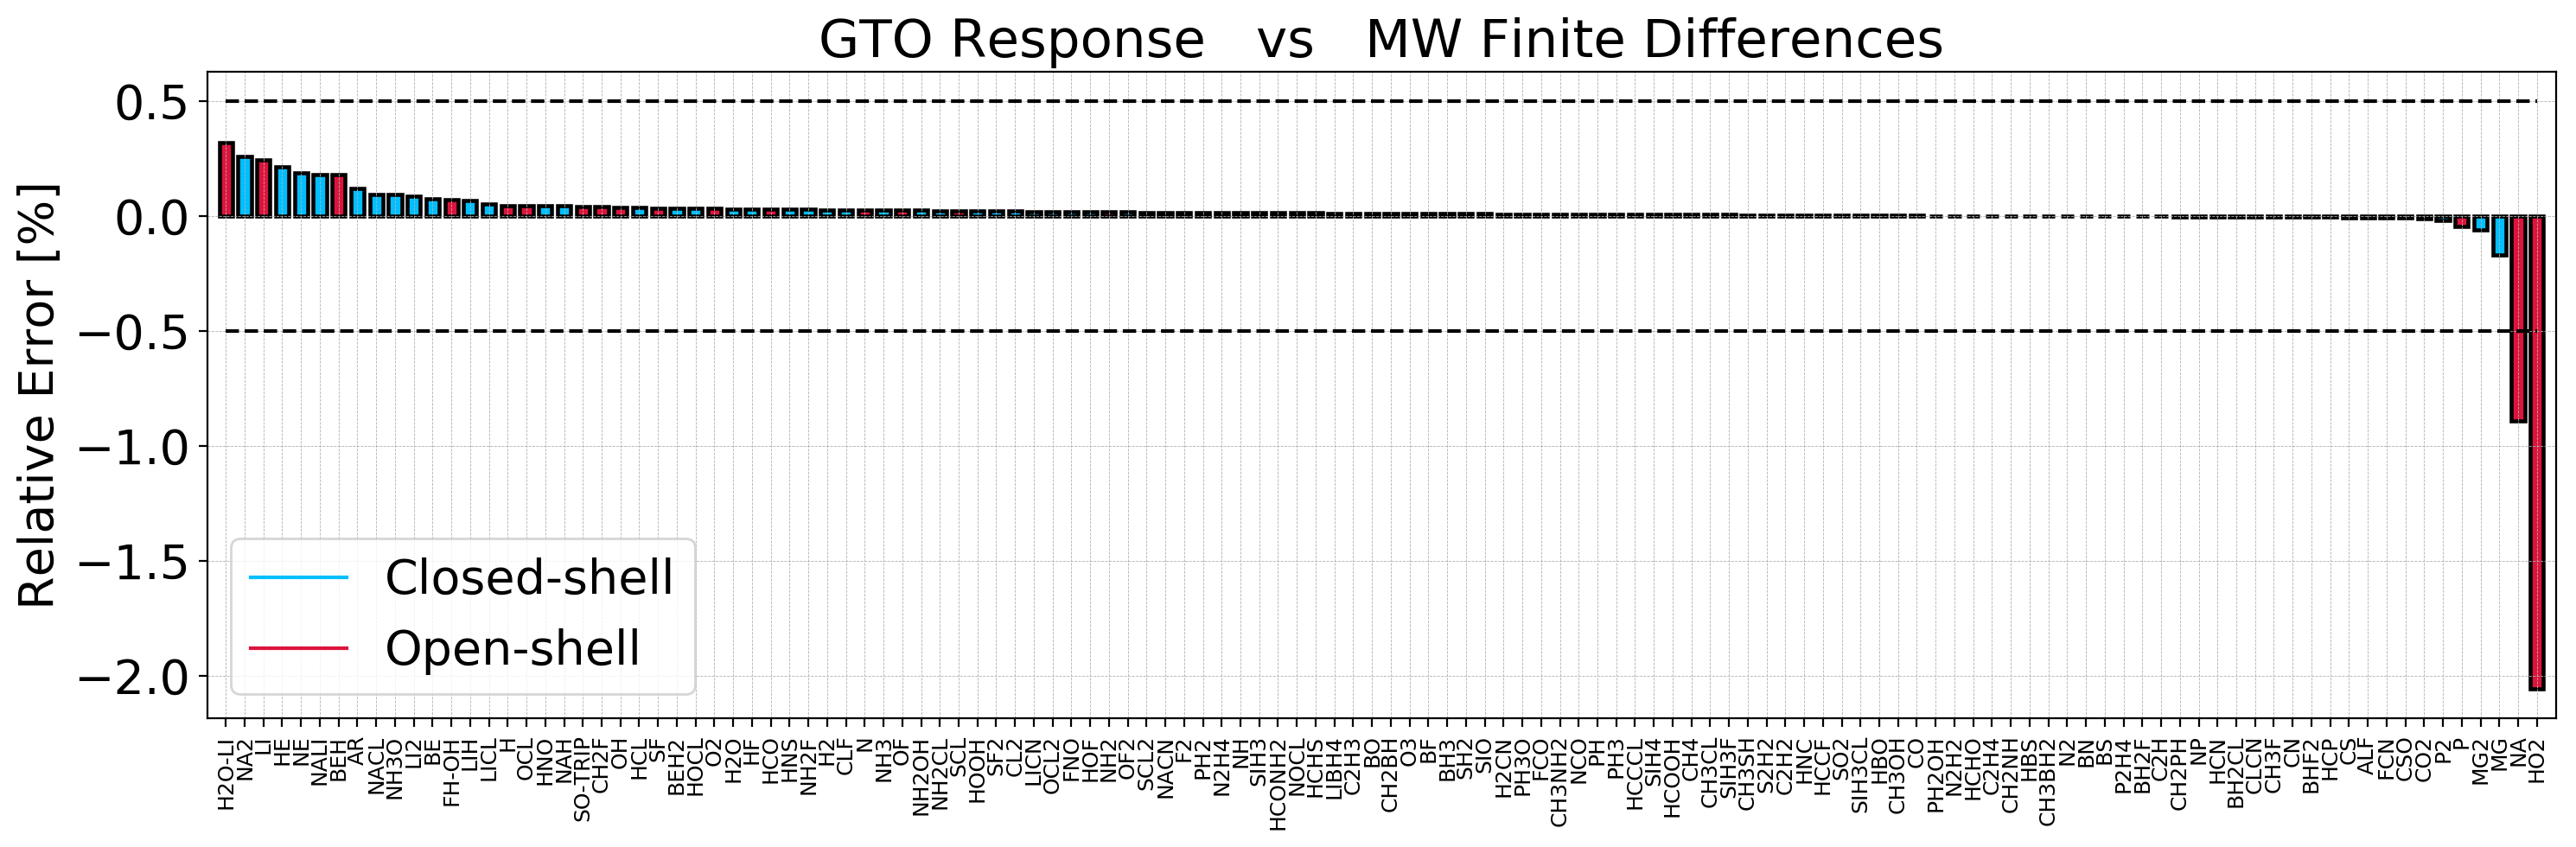

In [25]:
##########################################
# Here we can compare the analytical GTO polarizabilities with the numerical multiwavelet polarizabilities.
##########################################

# Get data structures
with open("mw_data_0001v2.yaml") as f, open("datafiles_orca_response_v2.yaml") as g, open("hg_data.yaml") as h:
    data1 = yaml.load(f)
    data2 = yaml.load(g)
    data3 = yaml.load(h)

# Only use species common in both data sets
skip = []
molecules = functions.common_species()
func = "pbe"

# Determine missing species
molecules_missing = []
for mol in data3.keys():
    if mol not in molecules:
        molecules_missing.append(mol)

# Define the xticks for the plots
xticks = range(len(molecules))

# Now extract the data we want: relative errors for the mean polarizability for each molecule
rel_err_mw_gto = [100 * (data1[mol][func]["mean"] / data2[mol][func]["mean"] - 1) for mol in molecules]

# Sort data based on the PBE relative error results
molecules_sorted, rel_err_mw_gto_sorted = zip(*sorted(zip(molecules, rel_err_mw_gto), reverse=True, key=operator.itemgetter(1)))

# Filter based on the magnitude of relative error
molecules_subset = []
rel_err_mw_gto_subset = []

# Define edge colors based on spin polarizability
spin_colors = ["deepskyblue" if data1[mol]["multiplicity"] == 1 else "crimson" for mol in molecules_sorted]

# Print some stats
print("Molecules with |RE| > 0.5 %:")
for re, mol in zip(rel_err_mw_gto, molecules):
    if abs(re) > 0.5:
        print("    ", mol, re)
print("Number of species in plot: ", len(molecules_sorted))
print("Species missing from HG data set: ", ", ".join(molecules_missing))
print("Mean relative error: ", sum(rel_err_mw_gto) / len(rel_err_mw_gto))
print("Root-mean-square relative error: ", math.sqrt(sum(map(lambda x: x**2, rel_err_mw_gto)) / len(molecules_sorted)))

# Define custom lines that we will use for making a custom legend
# that explains the red and blue colors
lines = [Line2D([0], [0], color="deepskyblue"),
         Line2D([0], [0], color="crimson")]

# Set up the figure with subplots
fontsize = 20
width = 0.7
fig = plt.figure(figsize=(15, 5), dpi=200)
ax = plt.gca()

ax.set_ylabel("Relative Error [%]", fontsize=fontsize)
ax.tick_params("y", labelsize=fontsize)
ax.set_xlim(-1, len(molecules_sorted))

# Plot data
for i in range(len(molecules_sorted)):
    ax.bar(xticks[i], rel_err_mw_gto_sorted[i], color=spin_colors[i], edgecolor="black", width=width, linewidth=1.65)

ax.plot(range(len(molecules_sorted)), [0.5 for i in range(len(molecules_sorted))], color="black", linestyle="--")
ax.plot(range(len(molecules_sorted)), [-0.5 for i in range(len(molecules_sorted))], color="black", linestyle="--")

# Place the molecule names on the xtick positions, rotation by 90 degrees
plt.xticks(xticks, [mol.upper() for mol in molecules_sorted], rotation=90, fontsize=9)

ax.grid(True, linestyle="--", linewidth=0.3)
plt.title("GTO Response   vs   MW Finite Differences", fontsize=fontsize+2)

plt.legend(lines, ["Closed-shell", "Open-shell"], fontsize=fontsize)
fig.tight_layout()
plt.show()